# Project Description and Goals
Across the United States, there are altercations that result in killings by police officers, whether on-duty or off-duty. Each case is considered as a person dying from being shot, beaten, restrained, intentionally hit by a police vehicle, pepper sprayed, tasered, or otherwise harmed by police. 

For our capstone, we are addressing the issue of police violence that has become a heated topic throughout the country in the recent years. As a team, we will be attempting to help law enforcement agencies spot risk factors so they may step in before risk transforms into actual harm.  

The open-sourced dataset we acquired from [Mapping Police Violence](https://mappingpoliceviolence.org/aboutthedata) has gathered over 9000 police killings from January 2013 to May 2021. Top drivers of civilian fatalities identified will shed light on changes to be made to save more lives. Then, we will use the features to apply to our classification models predicting the threat level of the victim (attacker or not).

### Objectives for this project include:
- Identifying the drivers of civilian fatalities. 
- Documenting the process and analysis throughout the data science pipeline.
- Constructing a classification model that can predict what the victim's threat level is, given the features of the dataset.
- Deliverables:
    - README.md file containing overall project information. 
    - A well-documented jupyter notebook detailing the data science pipeline process.
    - Python modules that automate the data acquisition, preparation, and exploration process.

### Initial Hypotheses:
- Does gender make a difference in alleged threat level?
- How does mental illness affect each gender?
- Do symptoms of mental illness play a role in threat level?
- Is race a factor for alleged threat level?
- Does the police officer having a bodycam make a difference in alleged threat level?
- Is cause of death and alleged threat level independent of one another?
- What are the fatalities by state: % killings vs pop
- Where and what areas result in more killings?

___
# Imports 
Import all necessary libraries and functions. 

In [1]:
import pandas as pd
import numpy as np

# Helper Functions
import wrangle as w 
import explore as exp
from explore import rfe, split, select_kbest

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Hypothesis tests
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

# Split data
from sklearn.model_selection import train_test_split

#Feature Engineering
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.feature_selection import RFE

# Evaluate models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Create models for classification ML:
# Decision Tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# K-Nearest Neighbor(KNN)  
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression


___
# Acquire Data

In [2]:
# reads data from MPV website's downloaded dataset
df = pd.read_excel('data.xlsx')
df.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID,Encounter Type (DRAFT),Initial Reported Reason for Encounter (DRAFT),Names of Officers Involved (DRAFT),Race of Officers Involved (DRAFT),Known Past Shootings of Officer(s) (DRAFT),Call for Service? (DRAFT)
0,Kalon Horton,29,Male,Black,NaN,2021-05-09,NaN,Lancaster,TX,NaN,...,NaN,NaN,NaN,NaN,Part 1 Violent Crime,gunshots,NaN,NaN,NaN,Yes
1,Name withheld by police,NaN,Male,Unknown Race,NaN,2021-05-09,90 S. Main St.,Leicester,MA,1524.0,...,NaN,Suburban,NaN,NaN,Other,deliberate car crash,NaN,NaN,NaN,Yes
2,Jeffrey Mark Murray,62,Male,Unknown Race,NaN,2021-05-09,NaN,Greenville,SC,NaN,...,NaN,NaN,NaN,NaN,Part 1 Violent Crime,murder,NaN,NaN,NaN,Yes
3,Everton Brown,56,Male,Unknown Race,NaN,2021-05-08,NaN,Baltimore,MD,NaN,...,NaN,NaN,NaN,NaN,Part 1 Violent Crime,murder,NaN,NaN,NaN,Yes
4,Felix Jerry Marquez,34,Male,Hispanic,NaN,2021-05-08,NaN,Riverside,CA,NaN,...,NaN,NaN,NaN,NaN,Person with a gun,person with a gun,NaN,NaN,NaN,No



### Initial Data Summarization

In [3]:
# rows and columns
df.shape

(9147, 35)

In [4]:
# list of column names and data types with information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9147 entries, 0 to 9146
Data columns (total 35 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype         
---  ------                                                                                                                                                                      --------------  -----         
 0   Victim's name                                                                                                                                                               9147 non-null   object        
 1   Victim's age                                                                                                                                                                9138 non-null   object        
 2   Victim's gender                                         

In [5]:
# check nulls
df.isnull().sum()

Victim's name                                                                                                                                                                    0
Victim's age                                                                                                                                                                     9
Victim's gender                                                                                                                                                                 10
Victim's race                                                                                                                                                                    0
URL of image of victim                                                                                                                                                        4265
Date of Incident (month/day/year)                                                                        

In [6]:
# specify useless columns and what to exclude for counts
useless_columns = df.columns[35:]
exclusions = ["Victim's name", 
              "URL of image of victim", 
              "Date of Incident (month/day/year)", 
              "Street Address of Incident", 
              "City", "State", "Zipcode", "County", 
              "Agency responsible for death", "ORI Agency Identifier (if available)", 
              "A brief description of the circumstances surrounding the death", 
              "Link to news article or photo of official document", 
              "Link to news article or photo of official document", 
              "WaPo ID (If included in WaPo database)", 
              "MPV ID", 
              "Fatal Encounters ID", 
              "Names of Officers Involved (DRAFT)"]

# getting value counts for specific columns
for column in df.columns:
    if column not in exclusions and column not in useless_columns:
        print(column.upper())
        print(df[column].value_counts())
        print("-------------------------------------")

VICTIM'S AGE
Unknown    331
25         299
27         294
31         290
28         289
          ... 
88           1
10           1
7            1
85           1
107          1
Name: Victim's age, Length: 89, dtype: int64
-------------------------------------
VICTIM'S GENDER
Male           8668
Female          453
Transgender       9
Unknown           6
Male              1
Name: Victim's gender, dtype: int64
-------------------------------------
VICTIM'S RACE
White                     3993
Black                     2306
Hispanic                  1631
Unknown Race               896
Asian                      135
Native American            130
Pacific Islander            52
Unknown race                 2
Asian/Pacific Islander       1
Hispanic                     1
Name: Victim's race, dtype: int64
-------------------------------------
CAUSE OF DEATH
Gunshot                                    8434
Gunshot, Taser                              273
Taser                                     

------------------------------------------------------
------------------------------------------------------


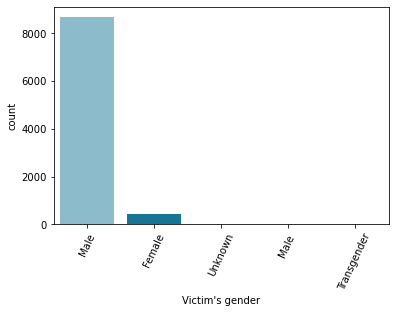

------------------------------------------------------
------------------------------------------------------


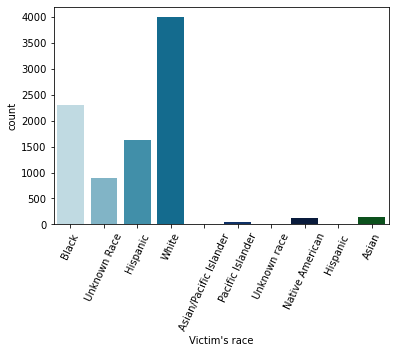

------------------------------------------------------
------------------------------------------------------


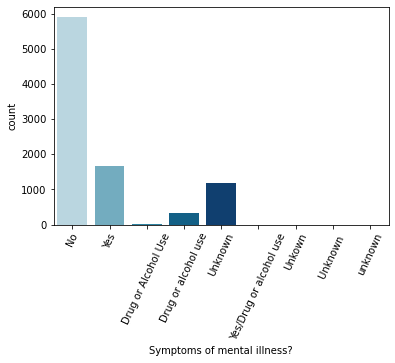

------------------------------------------------------
------------------------------------------------------


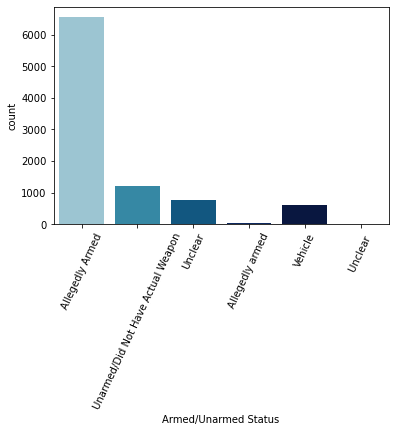

------------------------------------------------------
------------------------------------------------------


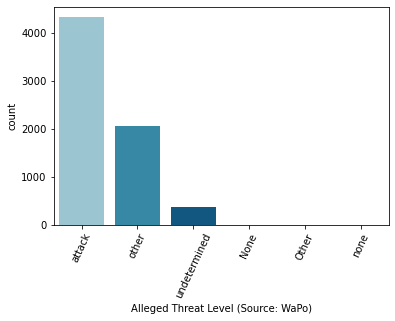

------------------------------------------------------
------------------------------------------------------


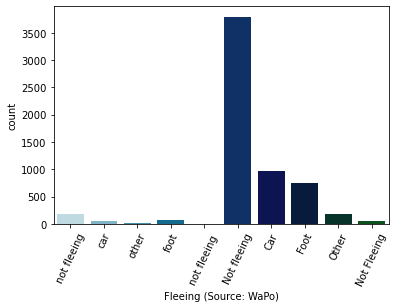

------------------------------------------------------
------------------------------------------------------


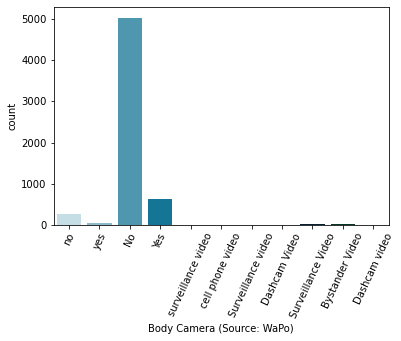

------------------------------------------------------
------------------------------------------------------


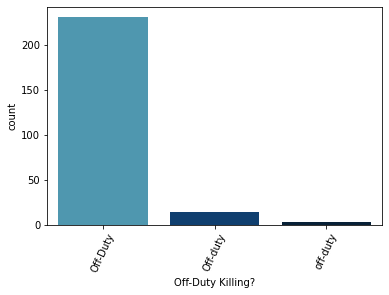

------------------------------------------------------
------------------------------------------------------


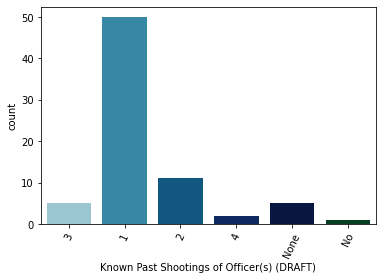

------------------------------------------------------
------------------------------------------------------


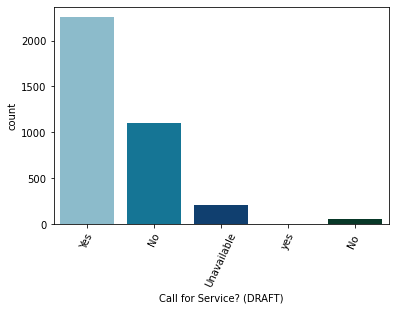

In [7]:
# specify more columns to exclude for univariate distributions
more_exclusions = ["Victim's age", 
                   "Cause of death", 
                   "Official disposition of death (justified or other)", 
                   "Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)", 
                   "Encounter Type (DRAFT)", 
                   "Initial Reported Reason for Encounter (DRAFT)", 
                   "Criminal Charges?",
                   "Race of Officers Involved (DRAFT)", 
                   "Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )"]

# univariate distributions
for column in df.columns:
    if column not in exclusions and column not in useless_columns and column not in more_exclusions:
        sns.countplot(x=df[column], data=df, palette = 'ocean_r')
        print("------------------------------------------------------")
        print("------------------------------------------------------")
        plt.xticks(rotation=65)
        plt.show()

### Takeaways
- There are a couple of unnecessary columns (begin with `Unnamed:`).
- Messy column names need to be renamed for better readability.
- A lot of columns are not needed due to nulls/unusable and will need to be dropped. 
- Most values in each column have a wide variety of text variation. These should be lowercased, stripped, and grouped. 
- Many nulls in dataset that need to be filled in or dropped.
- Dummy variables and encoding needs to be done to pretty much all of the dataset in order to model/evaluate. 
- Possibly a good idea to create age bins.
- Possible exploration with time series. Set `Date of Incident` as datetime index?



___
# Prepare and Split Data

In [8]:
#grab cleaned data frame from wrangle.py
df = w.wrangle_data(cached=False)
df.head()

,age,gender,race,date,city,state,zipcode,county,agency_responsible,cause_of_death,...,age_bins,unknown,under 12,12-17,18-24,25-34,35-44,45-54,55-64,65+
7,52,male,unknown race,2021-05-07,rutledge,tn,37861.0,grainger,"bean station police department, rutledge polic...",gunshot,...,45-54,0,0,0,0,0,0,1,0,0
8,47,male,white,2021-05-06,san andreas,ca,95249.0,calaveras,calaveras county sheriff's office,gunshot,...,45-54,0,0,0,0,0,0,1,0,0
9,49,male,white,2021-05-05,las vegas,nv,89104.0,clark,las vegas metropolitan police department,gunshot,...,45-54,0,0,0,0,0,0,1,0,0
10,27,male,black,2021-05-04,mesquite,tx,75150.0,dallas,mesquite police department,gunshot,...,25-34,0,0,0,0,1,0,0,0,0
12,1,male,black,2021-05-03,biloxi,ms,39532.0,harrison,biloxi police department,gunshot,...,under 12,0,1,0,0,0,0,0,0,0


In [9]:
#double check no nulls
df.isnull().sum()

age                                            0
gender                                         0
race                                           0
date                                           0
city                                           0
state                                          0
zipcode                                        0
county                                         0
agency_responsible                             0
cause_of_death                                 0
description_of_circumstances                   0
official_disposition                           0
criminal_charges_filed                         0
mental_illness                                 0
armed_unarmed_status                           0
alleged_weapon                                 0
alleged_threat_lvl                             0
fleeing                                        0
body_camera                                    0
geography                                      0
encounter_type_draft

In [10]:
#double check data types
df.dtypes

age                                                     int64
gender                                                 object
race                                                   object
date                                           datetime64[ns]
city                                                   object
state                                                  object
zipcode                                               float64
county                                                 object
agency_responsible                                     object
cause_of_death                                         object
description_of_circumstances                           object
official_disposition                                   object
criminal_charges_filed                                 object
mental_illness                                         object
armed_unarmed_status                                   object
alleged_weapon                                         object
alleged_

In [11]:
#split the data using the split function in explore.py
train, validate, test = split(df, stratify_by="alleged_threat_lvl")

#check split datasets
print('overall shape of dataframe:', df.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

#work w/ training data
train.head()

overall shape of dataframe: (8634, 60)
train: (4834, 60)
validate: (2073, 60)
test: (1727, 60)


,age,gender,race,date,city,state,zipcode,county,agency_responsible,cause_of_death,...,age_bins,unknown,under 12,12-17,18-24,25-34,35-44,45-54,55-64,65+
1554,25,male,black,2019-12-19,tempe,az,85281.0,maricopa,arizona department of public safety,gunshot,...,25-34,0,0,0,0,1,0,0,0,0
7137,26,male,hispanic,2014-11-16,east los angeles,ca,90022.0,los angeles,los angeles county sheriff's department,gunshot,...,25-34,0,0,0,0,1,0,0,0,0
2043,23,male,white,2019-07-09,cleveland,oh,44144.0,cuyahoga,brooklyn police department,gunshot,...,18-24,0,0,0,1,0,0,0,0,0
8579,37,male,hispanic,2013-07-02,las cruces,nm,88005.0,dona ana,las cruces police department,gunshot,...,35-44,0,0,0,0,0,1,0,0,0
8556,27,male,white,2013-07-08,sewickley,pa,15143.0,allegheny,"sewickley police department, allegheny county ...",gunshot,...,25-34,0,0,0,0,1,0,0,0,0


### Takeaway
- Data is prepped/split and ready to be explored, modeled, and evaluated.


___
# Explore Data
#### Address questions posed in planning
- Does gender make a difference in alleged threat level?
- How does mental illness affect each gender?
- Do symptoms of mental illness play a role in threat level?
- Is race a factor for alleged threat level?
- Does bodycam make a difference in alleged threat level?
- Is cause of death and alleged threat level independent of one another?
- What areas in geography are resulting in more killings?
- What are the fatalities by state: % killings vs pop

## • Visualizations

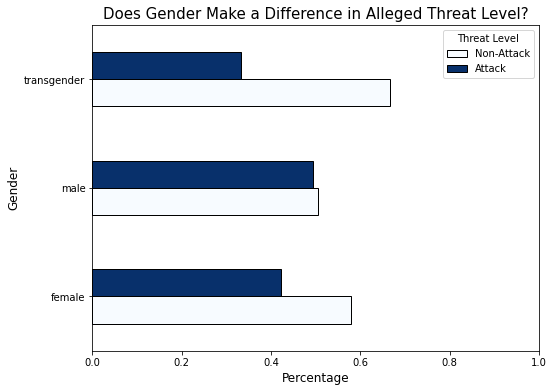

alleged_threat_lvl,0.0,1.0
gender,,
female,0.578261,0.421739
male,0.505002,0.494998
transgender,0.666667,0.333333


In [12]:
#visualize gender vs alleged threat level
ax = pd.crosstab(train.gender, train.alleged_threat_lvl, normalize ='index').plot.barh(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Non-Attack', 'Attack'], 
          bbox_to_anchor=(1,1), 
          title='Threat Level')

#customize chart
plt.title("Does Gender Make a Difference in Alleged Threat Level?", fontsize = 15)
plt.ylabel("Gender", fontsize = 12)
plt.xlabel('Percentage', fontsize = 12)
ax.tick_params(labelsize=10)
plt.xlim([0.0, 1.0])
plt.show()

#get percentages df
percentages = pd.crosstab(train.gender, train.alleged_threat_lvl, normalize = 'index')
percentages

### Takeaways
- Highest percentage of non-attacks are transgender. Second highest is female.
- Highest percentage of attacks are male. Second highest is female.
- Males are almost equally likely to be an attack or non-attack threat level.

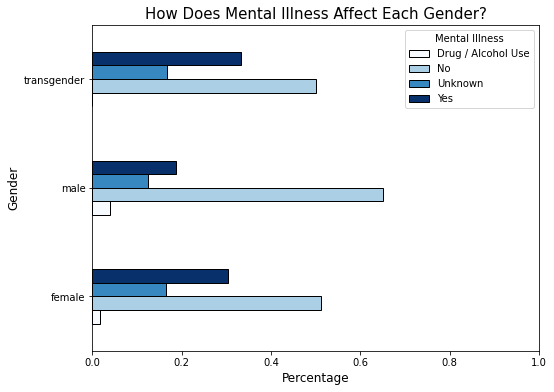

mental_illness,drug or alcohol use,no,unknown,yes
gender,,,,
female,0.017391,0.513043,0.165217,0.304348
male,0.038278,0.650065,0.125054,0.186603
transgender,0.000000,0.500000,0.166667,0.333333


In [13]:
#visualize mental illness per gender
ax = pd.crosstab(train.gender, train.mental_illness, normalize ='index').plot.barh(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Drug / Alcohol Use', 'No', 'Unknown', 'Yes'], 
          bbox_to_anchor=(1,1), 
          title='Mental Illness')

#customize chart
plt.title("How Does Mental Illness Affect Each Gender?", fontsize = 15)
plt.ylabel("Gender", fontsize = 12)
plt.xlabel('Percentage', fontsize = 12)
ax.tick_params(labelsize=10)
plt.xlim([0.0, 1.0])
plt.show()

#get percentages df
percentages = pd.crosstab(train.gender, train.mental_illness, normalize = 'index')
percentages

### Takeaways
- Males are most often categorized as not having a mental illness, however, they have a high threat level (according to previous visual). 
- All genders have higher percentages of no mental illness. Could this be related to limited mental health awareness/support across the country?
- Males have the highest percentage of drug / alchohol use instances.
- Unknown mental status is almost equal across genders.

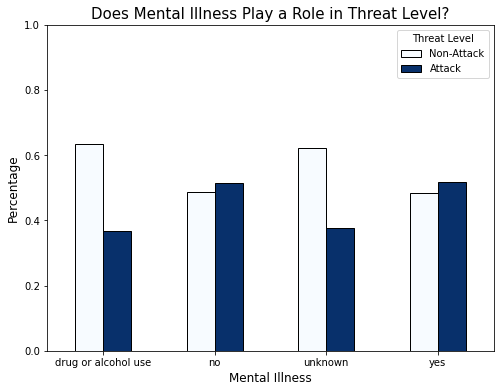

alleged_threat_lvl,0.0,1.0
mental_illness,,
drug or alcohol use,0.633333,0.366667
no,0.486817,0.513183
unknown,0.622150,0.377850
yes,0.482796,0.517204


In [14]:
#visualize mental illness vs threat level
ax = pd.crosstab(train.mental_illness, train.alleged_threat_lvl, normalize ='index').plot.bar(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Non-Attack', 'Attack'], 
          bbox_to_anchor=(1,1), 
          title='Threat Level')

#customize chart
plt.title("Does Mental Illness Play a Role in Threat Level?", fontsize = 15)
plt.ylabel("Percentage", fontsize = 12)
plt.xlabel('Mental Illness', fontsize = 12)
ax.tick_params(labelsize=10)
plt.ylim([0.0, 1.0])
plt.xticks(rotation=0)
plt.show()

#get percentages df
percentages = pd.crosstab(train.mental_illness, train.alleged_threat_lvl, normalize = 'index')
percentages

### Takeaways
- People with no mental illness have been characterized as having an 'attack' threat level more often than not being attackers, but not by much. 
- Same for people with mental illness (more likely to be attacks than non-attacks, but not by much).
- Highest percentage of non-attacks are people under the influence of drugs/alcohol or people with unknown mental status. 

In [15]:
#ax = sns.countplot(data=train, x='mental_illness', hue='alleged_threat_lvl', palette = 'ocean_r')
#ax = pd.crosstab(train.mental_illness, train.alleged_threat_lvl, normalize ='index').plot(kind = 'bar', figsize=(15, 10), cmap=plt.cm.get_cmap('ocean_r'), ec="black")

#x, y, hue = "mental_illness", "percent", "alleged_threat_lvl"
#hue_order = ["Non-Attack", "Attack"]

#ax = (train[x]
# .groupby(train[hue])
# .value_counts(normalize='index')
# .rename(y)
# .reset_index()
# .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "ocean_r"))


#customize legend
#legend_labels, _= ax.get_legend_handles_labels()
#ax.legend(legend_labels, ['Non-Attack','Attack'], 
#          bbox_to_anchor=(1,1), 
#          title='Threat Level')

#customize chart
#plt.title('Does Mental Illness Play a Role in Threat Level?')
#plt.xlabel('Mental Illness')
#plt.ylabel('Percentage')
#plt.ylim([0.0, 1.0])
#plt.show()

#get percentages df
#percentages = pd.crosstab(train.mental_illness, train.alleged_threat_lvl, normalize = 'index')
#percentages.plot.bar(cmap='Blues', ec='black', )
#percentages

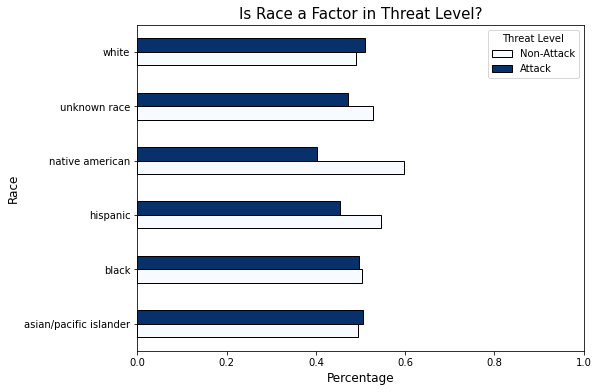

alleged_threat_lvl,0.0,1.0
race,,
asian/pacific islander,0.494949,0.505051
black,0.502447,0.497553
hispanic,0.546682,0.453318
native american,0.597015,0.402985
unknown race,0.527311,0.472689
white,0.489649,0.510351


In [16]:
#visualize race vs alleged threat level
ax = pd.crosstab(train.race, train.alleged_threat_lvl, normalize ='index').plot.barh(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Non-Attack', 'Attack'], 
          bbox_to_anchor=(1,1), 
          title='Threat Level')

#customize chart
plt.title("Is Race a Factor in Threat Level?", fontsize = 15)
plt.ylabel("Race", fontsize = 12)
plt.xlabel('Percentage', fontsize = 12)
ax.tick_params(labelsize=10)
plt.xlim([0.0, 1.0])
plt.show()

#get percentages df
percentages = pd.crosstab(train.race, train.alleged_threat_lvl, normalize = 'index')
percentages

### Takeaways
- The highest occurrence of non-attacks are seen in Native Americans. Second highest is Hispanics.
- The highest occurrence of attacks are seen in White races. Second highest appears to be Asians/Pacific Islanders. 
- Black races are almost equally likely to result in attack/non-attack threat levels.
- There is a lot of unknown races in the data. Why?

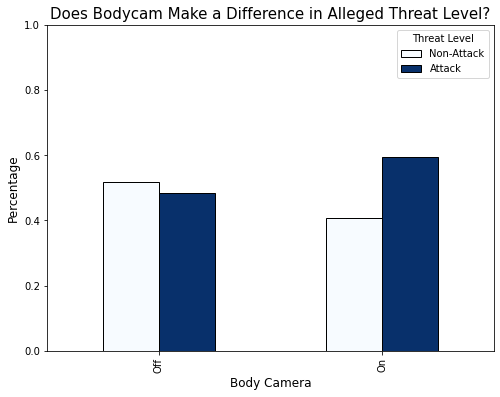

alleged_threat_lvl,0.0,1.0
body_camera,,
0.0,0.516726,0.483274
1.0,0.405714,0.594286


In [17]:
#visualize body camera vs alleged threat level
ax = pd.crosstab(train.body_camera, train.alleged_threat_lvl, normalize ='index').plot.bar(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Non-Attack', 'Attack'], 
          bbox_to_anchor=(1,1), 
          title='Threat Level')

#customize chart
plt.title("Does Bodycam Make a Difference in Alleged Threat Level?", fontsize = 15)
plt.ylabel("Percentage", fontsize = 12)
plt.xlabel('Body Camera', fontsize = 12)
ax.tick_params(labelsize=10)
x_labels = ['Off', 'On']
ax.set_xticklabels(x_labels)

plt.ylim([0.0, 1.0])
plt.show()

#get percentages df
percentages = pd.crosstab(train.body_camera, train.alleged_threat_lvl, normalize = 'index')
percentages

### Takeaways
- When bodycam is off, there seems to be more non-attacks than attacks. Why is there non-attack threat levels resulting in these fatalities?
- When bodycam is on, there is a higher chance of an attack than a non-attack.

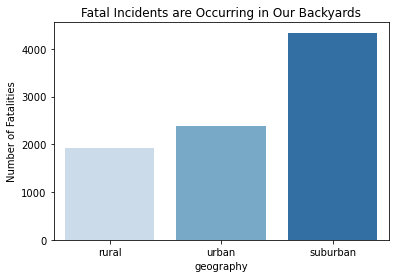

In [18]:
#visualize what areas in geography are resulting in more killings?
sns.countplot(data=df, x='geography', palette='Blues')
plt.title("Fatal Incidents are Occurring in Our Backyards")
plt.ylabel('Number of Fatalities')
plt.show()

### Takeaways
- Suburban neighborhoods have the highest number of fatalities. 
- Rural areas have the least amount of fatal incidents. 

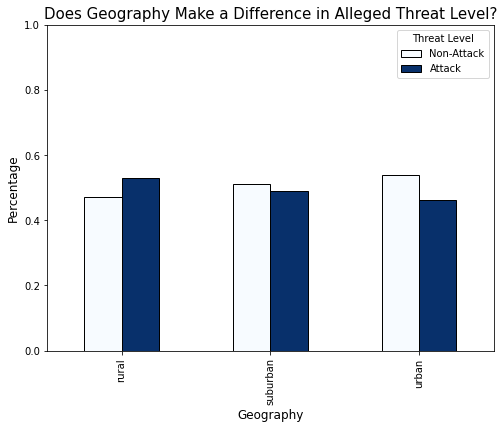

alleged_threat_lvl,0.0,1.0
geography,,
rural,0.470919,0.529081
suburban,0.509611,0.490389
urban,0.537415,0.462585


In [19]:
#visualize geography vs alleged threat level
ax = pd.crosstab(train.geography, train.alleged_threat_lvl, normalize ='index').plot.bar(figsize=(8, 6), cmap=plt.cm.get_cmap('Blues'), ec="black")

#customize legend
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Non-Attack', 'Attack'], 
          bbox_to_anchor=(1,1), 
          title='Threat Level')

#customize chart
plt.title("Does Geography Make a Difference in Alleged Threat Level?", fontsize = 15)
plt.ylabel("Percentage", fontsize = 12)
plt.xlabel('Geography', fontsize = 12)
ax.tick_params(labelsize=10)
#x_labels = ['Off', 'On']
#ax.set_xticklabels(x_labels)

plt.ylim([0.0, 1.0])
plt.show()

#get percentages df
percentages = pd.crosstab(train.geography, train.alleged_threat_lvl, normalize = 'index')
percentages

### Takeaways
- Not much variation, but there is a higher percentage of attack threat level happening in rural areas.
- Highest percentage of non-attack threat levels are happening in urban areas. 
- Suburban areas are almost equally likely to be attack/non-attacks. Slightly higher percentage for non-attacks. 


___

## • Hypothesis Testing

In [20]:
#t-test for gender vs threat level
female = train[train.gender == 'female']
male = train[train.gender == 'male']
transg = train[train.gender == 'transgender']
not_male = train[train.gender != 'male']

male_att = male.alleged_threat_lvl
non_male_att = not_male.alleged_threat_lvl

null_hypothesis = "There is not a difference between male attackers and the remaining population."
alternative_hypothesis = "Attacker status for males & total population are different."
confidence_level = .95
a = 1 - confidence_level

t, p = stats.ttest_ind(male_att, non_male_att)
print(t, p)

if p < a:
    print("We reject the null hypothesis.")
    print(f"We can move forward with alternative hypothesis: {alternative_hypothesis}")
else:
    print("We fail to reject the null hypothesis")
    print(f"Not enough evidence to support the claim: {null_hypothesis}")

2.2636340254396954 0.02364079475189402
We reject the null hypothesis.
We can move forward with alternative hypothesis: Attacker status for males & total population are different.


In [21]:
#chi2 test for mental illness vs alleged threat level
exp.chi2_matts(train, 'mental_illness', 'alleged_threat_lvl', alpha=0.05)

Observed

[[ 114   66]
 [1514 1596]
 [ 382  232]
 [ 449  481]]
---
Expected

[[  91.56392222   88.43607778]
 [1582.02110054 1527.97889946]
 [ 312.33471245  301.66528755]
 [ 473.08026479  456.91973521]]
---

chi^2 = 51.2639
p     = 0.0000

Because the p-value: 0.0 is less than alpha: 0.05, we can reject the null hypothesis


In [22]:
#chi2 test for race vs alleged threat level
exp.chi2_matts(train, 'race', 'alleged_threat_lvl', alpha=0.05)

Observed

[[  49   50]
 [ 616  610]
 [ 486  403]
 [  40   27]
 [ 251  225]
 [1017 1060]]
---
Expected

[[  50.36015722   48.63984278]
 [ 623.65204799  602.34795201]
 [ 452.22403806  436.77596194]
 [  34.0821266    32.9178734 ]
 [ 242.13570542  233.86429458]
 [1056.5459247  1020.4540753 ]]
---

chi^2 = 11.1651
p     = 0.0482

Because the p-value: 0.0482 is less than alpha: 0.05, we can reject the null hypothesis


In [23]:
#chi2 test for bodycam vs alleged threat level
exp.chi2_matts(train, 'body_camera', 'alleged_threat_lvl', alpha=0.05)

Observed

[[2317 2167]
 [ 142  208]]
---
Expected

[[2280.95904013 2203.04095987]
 [ 178.04095987  171.95904013]]
---

chi^2 = 15.5676
p     = 0.0001

Because the p-value: 0.0001 is less than alpha: 0.05, we can reject the null hypothesis


### Takeaways
- All four statistical tests rejected the null hypothesis.
    - T-test demonstrates there is a difference between male attackers and the remaining population.
    - 1st Chi^2 test demonstrates that mental status is dependent on alleged threat level.
    - 2nd Chi^2 test demonstrates that race is dependent on alleged threat level.
    - 3rd chi^2 test demonstrates that bodycam is dependent on alleged threat level.


___
# Modeling

In [24]:
#set up X inputs and y target variable for each split
X_train = train.drop(columns=['alleged_threat_lvl'])
y_train = train.alleged_threat_lvl

X_validate = validate.drop(columns=['alleged_threat_lvl'])
y_validate = validate.alleged_threat_lvl

X_test = test.drop(columns=['alleged_threat_lvl'])
y_test = test.alleged_threat_lvl

In [25]:
# dropping columns that are not numeric datatypes
dropcols = ['date', 
            'gender',
            'race',
            'city',
            'state',
            'zipcode',
            'county',
            'agency_responsible',
            'cause_of_death',
            'description_of_circumstances',
            'official_disposition',
            'criminal_charges_filed',
            'mental_illness',
            'armed_unarmed_status',
            'alleged_threat_lvl',
            'alleged_weapon',
            'fleeing',
            'geography',
            'encounter_type_draft',
            'initial_reported_reason_for_encounter_draft',
            'known_past_shootings_of_officer_draft',
            'age_bins']

X_train = train.drop(columns=dropcols)
X_validate = validate.drop(columns=dropcols)
X_test = test.drop(columns=dropcols)


___
## • Feature Importance

#### Select K Best
- Uses statistical tests to determine each feature's usefulness in predicting the target variable. 
- Ranks the features and then select the K best features.

In [26]:
f_features = select_kbest(X_train, y_train, 15)
f_features

['age',
 'body_camera',
 'was_fleeing',
 'was_allegedly_armed',
 'was_unarmed',
 'was_domestic_disturbance',
 'was_mental_health_welfare_check',
 'was_traffic_stop',
 'was_violent_crime_part_1',
 'mntlill_drug or alcohol use',
 'mntlill_no',
 'mntlill_unknown',
 'rural',
 'under 12',
 '55-64']

#### Recursive Feature Elimination (RFE)
- Recursively removes attributes to meet the number of required features and then builds a model on those attributes that remain to see if you can you match or improve performance with a smaller subset.

In [27]:
rfe_features = rfe(X_train, y_train, 15)
rfe_features

['is_male',
 'is_transgender',
 'was_fleeing',
 'was_allegedly_armed',
 'was_unarmed',
 'was_vehicle',
 'was_domestic_disturbance',
 'was_mental_health_welfare_check',
 'was_person_with_a_weapon',
 'was_traffic_stop',
 'was_violent_crime_part_1',
 'is_native american',
 'mntlill_no',
 'cod_lethal',
 'under 12']

In [28]:
combo_feats = list(set(f_features + rfe_features))
print(len(combo_feats))
combo_feats

21


['rural',
 'cod_lethal',
 'was_person_with_a_weapon',
 'mntlill_no',
 'was_violent_crime_part_1',
 '55-64',
 'age',
 'was_mental_health_welfare_check',
 'was_allegedly_armed',
 'was_traffic_stop',
 'was_fleeing',
 'under 12',
 'was_domestic_disturbance',
 'mntlill_drug or alcohol use',
 'is_transgender',
 'is_male',
 'was_unarmed',
 'is_native american',
 'was_vehicle',
 'mntlill_unknown',
 'body_camera']

In [29]:
#specify combined features that reduces multicollinearity
combo_feats = ['55-64',
               'is_native american',
               'mntlill_no',
               'under 12',
               'was_traffic_stop',
               'body_camera',
               'age',
               'was_allegedly_armed',
               'is_black',
               'was_domestic_disturbance',
               'was_fleeing',
               'cod_lethal',
               'was_mental_health_welfare_check',
               'is_white',
               'was_violent_crime_part_1',
               'was_vehicle',
               'mntlill_drug or alcohol use',
               'is_transgender',
               'is_female']
 
print(len(combo_feats))

19



___
## • Identify Baseline

In [30]:
#baseline prediction: the most prevalent class in training dataset(the mode)
train.alleged_threat_lvl.value_counts()

0.0    2459
1.0    2375
Name: alleged_threat_lvl, dtype: int64

In [31]:
#baseline model would be to predict 0 since it is most prevalant
#baseline accuracy:
baseline_accuracy = (train.alleged_threat_lvl == 0).mean()

print(f'baseline accuracy: {baseline_accuracy: .2}')

baseline accuracy:  0.51



___
## • Model on Train

### Decision Tree

In [32]:
#create Decision Tree model (specifying max_depth argument and combo_feats)
dt = DecisionTreeClassifier(max_depth=3, random_state=123)

#fit model on combo_feats
dt.fit(X_train[combo_feats], y_train)

#get predictions from model
y_pred = dt.predict(X_train[combo_feats])

#compute accuracy
dt_train_acc = round(dt.score(X_train[combo_feats], y_train), 2)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy of Decision Tree classifier on combo_feats (max_depth = 3): {:.2f}'
     .format(dt.score(X_train[combo_feats], y_train)))

Baseline is 0.51
----------------
Accuracy of Decision Tree classifier on combo_feats (max_depth = 3): 0.71


### Random Forest

In [77]:
#create Random Forest model (specifying max_depth/min_samples_leaf arguments and combo_feats)
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

#fit model on combo_feats
rf.fit(X_train[combo_feats], y_train)

#get predictions from model
y_pred = rf.predict(X_train[combo_feats])

#compute accuracy
rf_train_acc = round(rf.score(X_train[combo_feats], y_train), 2)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy of Random Forest classifier on combo_feats (max_depth = 5, min_samples_leaf = 3): {:.2f}'
     .format(rf.score(X_train[combo_feats], y_train)))

Baseline is 0.51
----------------
Accuracy of Random Forest classifier on combo_feats (max_depth = 5, min_samples_leaf = 3): 0.71


### K-Nearest Neighbor (KNN)

In [78]:
#create KNN model (specifying n_neighbors argument and combo_feats)
knn = KNeighborsClassifier(n_neighbors=20)

#fit model on combo_feats
knn.fit(X_train[combo_feats], y_train)

#get predictions from model
y_pred = knn.predict(X_train[combo_feats])

#compute accuracy
knn_train_acc = round(knn.score(X_train[combo_feats], y_train), 2)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy of KNN classifier on combo_feats (n_neighbors = 20): {:.2f}'
     .format(knn.score(X_train[combo_feats], y_train)))

Baseline is 0.51
----------------
Accuracy of KNN classifier on combo_feats (n_neighbors = 20): 0.70


### Logistic Regression

In [79]:
#create Logistic Regression model (default parameters, specifying combo_feats)
logit = LogisticRegression(random_state=123)

#fit model on combo_feats
logit.fit(X_train[combo_feats], y_train)

#get predictions from model
y_pred = logit.predict(X_train[combo_feats])

#compute accuracy
logit_train_acc = round(logit.score(X_train[combo_feats], y_train), 2)

#compare to baseline
print("Baseline is", round(baseline_accuracy, 2))
print("----------------")
print('Accuracy of Logistic Regression classifier on combo_feats (default parameters): {:.2f}'
     .format(logit.score(X_train[combo_feats], y_train)))

Baseline is 0.51
----------------
Accuracy of Logistic Regression classifier on combo_feats (default parameters): 0.70


### Takeways:
- **Decision Tree** model (dt) specifying max_depth argument of 3 and using combo_feats:
    - Score of 71% accuracy
    
    
    
- **Random Forest** model (rf) specifying max_depth argument of 5, min_samples_leaf argument of 3 and using combo_feats:
    - Score of 72% accuracy
    
    
    
- **K-Nearest Neighbor** model (knn) specifying n_neighbors argument of 20 and using combo_feats:
    - Score of 70% accuracy
    
    
    
- **Logistic Regression** model (logit) using default parameters and combo_feats:
    - Score of 70% accuracy

Next, compare scores to validate (out-of-sample data).


___
## • Model on Validate

In [80]:
#dt's metrics on validate

#evaluate on validate sample
y_pred = dt.predict(X_validate[combo_feats])

#compute accuracy
dt_val_acc = round(dt.score(X_validate[combo_feats], y_validate), 2)

#compare train to validate
print('Accuracy of Decision Tree classifier on train set: {:.2f}'
     .format(dt.score(X_train[combo_feats], y_train)))
print("--------------------------------------------------------------")
print("Decision Tree classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Decision Tree classifier on train set: 0.71
--------------------------------------------------------------
Decision Tree classifier on validate set:
              precision    recall  f1-score   support

         0.0       0.77      0.62      0.69      1054
         1.0       0.67      0.81      0.74      1019

    accuracy                           0.71      2073
   macro avg       0.72      0.71      0.71      2073
weighted avg       0.72      0.71      0.71      2073



In [81]:
#rf's metrics on validate

#evaluate on validate sample
y_pred = rf.predict(X_validate[combo_feats])

#compute accuracy
rf_val_acc = round(rf.score(X_validate[combo_feats], y_validate), 2)

#compare train to validate
print('Accuracy of Random Forest classifier on train set: {:.2f}'
     .format(rf.score(X_train[combo_feats], y_train)))
print("--------------------------------------------------------------")
print("Random Forest classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Random Forest classifier on train set: 0.71
--------------------------------------------------------------
Random Forest classifier on validate set:
              precision    recall  f1-score   support

         0.0       0.74      0.69      0.71      1054
         1.0       0.70      0.75      0.72      1019

    accuracy                           0.72      2073
   macro avg       0.72      0.72      0.72      2073
weighted avg       0.72      0.72      0.72      2073



In [82]:
#knn's metrics on validate

#evaluate on validate sample
y_pred = knn.predict(X_validate[combo_feats])

#compute accuracy
knn_val_acc = round(knn.score(X_validate[combo_feats], y_validate), 2)

#compare train to validate
print('Accuracy of KNN classifier on train set: {:.2f}'
     .format(knn.score(X_train[combo_feats], y_train)))
print("--------------------------------------------------------------")
print("KNN classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of KNN classifier on train set: 0.70
--------------------------------------------------------------
KNN classifier on validate set:
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68      1054
         1.0       0.67      0.63      0.65      1019

    accuracy                           0.67      2073
   macro avg       0.67      0.67      0.67      2073
weighted avg       0.67      0.67      0.67      2073



In [83]:

#logit's metrics on validate

#evaluate on validate sample
y_pred = logit.predict(X_validate[combo_feats])

#compute accuracy
logit_val_acc = round(logit.score(X_validate[combo_feats], y_validate), 2)

#compare train to validate
print('Accuracy of Logistic Regression classifier on train set: {:.2f}'
     .format(logit.score(X_train[combo_feats], y_train)))
print("--------------------------------------------------------------")
print("Logistic Regression classifier on validate set:")
print(classification_report(y_validate, y_pred))

Accuracy of Logistic Regression classifier on train set: 0.70
--------------------------------------------------------------
Logistic Regression classifier on validate set:
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71      1054
         1.0       0.70      0.69      0.69      1019

    accuracy                           0.70      2073
   macro avg       0.70      0.70      0.70      2073
weighted avg       0.70      0.70      0.70      2073



In [84]:
# Build dataframe to record accuracy (starting with decision tree)
metric_df = pd.DataFrame(data=[{
    'Model': 'Decision Tree', 
    'Baseline': round(baseline_accuracy, 2),
    'Train Accuracy': round(dt_train_acc, 2),
    'Validate Accuracy': round(dt_val_acc, 2)}])

# append dataframe to record accuracy on random forest
metric_df = metric_df.append({
    'Model': 'Random Forest', 
    'Baseline': round(baseline_accuracy, 2),
    'Train Accuracy': round(rf_train_acc, 2),
    'Validate Accuracy':round(rf_val_acc, 2)}, ignore_index=True)

# append dataframe to record accuracy on knn
metric_df = metric_df.append({
    'Model': 'K-Nearest Neighbor', 
    'Baseline': round(baseline_accuracy, 2),
    'Train Accuracy': round(knn_train_acc, 2),
    'Validate Accuracy':round(knn_val_acc, 2)}, ignore_index=True)

# append dataframe to record accuracy on logistic regression
metric_df = metric_df.append({
    'Model': 'Logistic Regression', 
    'Baseline': round(baseline_accuracy, 2),
    'Train Accuracy': round(logit_train_acc, 2),
    'Validate Accuracy':round(logit_val_acc, 2)}, ignore_index=True)


metric_df

,Model,Baseline,Train Accuracy,Validate Accuracy
0,Decision Tree,0.51,0.71,0.71
1,Random Forest,0.51,0.71,0.72
2,K-Nearest Neighbor,0.51,0.70,0.67
3,Logistic Regression,0.51,0.70,0.70


### Takeaways

**Random Forest** is the best-performing model and will be evaluated on test data.



___
## • Model on Test

In [85]:
#evaluate on test sample 
y_pred_test = rf.predict(X_test[combo_feats])

#compute accuracy
rf_test_acc = round(rf.score(X_test[combo_feats], y_test), 2)

print("Random Forest Model:")
print(classification_report(y_test, y_pred_test))

Random Forest Model:
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.71       879
         1.0       0.70      0.73      0.71       848

    accuracy                           0.71      1727
   macro avg       0.71      0.71      0.71      1727
weighted avg       0.71      0.71      0.71      1727



In [86]:
#import Graphviz
import graphviz
from graphviz import Graph
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz


trees = rf.estimators_

# Our Random Forest contains 100 trees
print(len(trees))

100


In [87]:
rfcn = pd.DataFrame(data = y_test)
rfcn['alleged_threat_lvl'] = rfcn['alleged_threat_lvl'].astype(str)
rfcn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1727 entries, 8304 to 8700
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   alleged_threat_lvl  1727 non-null   object
dtypes: object(1)
memory usage: 27.0+ KB


In [99]:
# Extract the first tree for visualization
rf1 = rf.estimators_[67]
fn=['55-64','is_native american','mntlill_no','under 12','was_traffic_stop','body_camera','age','was_allegedly_armed',
    'is_black','was_domestic_disturbance','was_fleeing','cod_lethal','was_mental_health_welfare_check',
    'is_white','was_violent_crime_part_1','was_vehicle','mntlill_drug or alcohol use','is_transgender','is_female']
cn=rfcn.alleged_threat_lvl

# Visualize the model so it can explain itself!
dot_data = export_graphviz(rf1, feature_names= fn, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('rf7', view=True)

'rf7.pdf'

In [91]:
# append dataframe to record accuracy on final random forest
metric_df = metric_df.append({
    'Model': 'Random Forest', 
    'Baseline': round(baseline_accuracy, 2),
    'Train Accuracy': round(rf_train_acc, 2),
    'Validate Accuracy':round(rf_val_acc, 2),
    'Test Accuracy': round(rf_test_acc, 2)}, ignore_index=True)

In [43]:
metric_df

,Model,Baseline,Train Accuracy,Validate Accuracy,Test Accuracy
0,Decision Tree,0.51,0.71,0.71,NaN
1,Random Forest,0.51,0.72,0.72,NaN
2,K-Nearest Neighbor,0.51,0.70,0.67,NaN
3,Logistic Regression,0.51,0.70,0.70,NaN
4,Random Forest,0.51,0.72,0.72,0.72



___
# Conclusion

### Takeaways
- All models had roughly the same score for train and validate sets.
- K-Nearest neighbor model performed the worst on out-of-sample data.
- The best performing model uses a Random Forest algorithm and combined features from Select K Best and Recursive Feature Elimination lists.
- Our final Random Forest model increased by 21% from a baseline accuracy of 51% to 72% accuracy on out-of-sample data.


### Drivers
- The top drivers of predicting a victim's threat level were encounter type of incident, gender, race, armed/unarmed status, mental illness, age, geography, fleeing events, and body camera reports.
- These drivers can be used to shed light on changes to be made in law enforcement and to help law enforcement agencies spot risk factors, so they may step in before risk transforms into actual harm.


### Next Steps
- Fill in missing values manually as best as possible based on the description column in the dataset (large amount of data missing). 
- Natural language processing exploration on description of incident. 


#### Report containing summarization of notebook can be found [here](link to presentation).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=258e71fc-cf2b-48c3-8461-70ecd9787aa1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>